# Segmentación de Productos y Análisis por Tienda
## Big Mart Sales Prediction - Business Intelligence con Clustering

Este notebook implementa un flujo completo de Business Intelligence para segmentar productos y analizar su comportamiento por tienda usando técnicas de clustering.


In [25]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


# Fase A: Exploración Inicial

En esta fase realizaremos una exploración básica del dataset para entender su estructura, identificar variables clave y describir el contexto de negocio.


In [26]:
# Cargar el dataset
df = pd.read_csv('train_v9rqX0R.csv')

# Información básica del dataset
print("="*80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*80)
print(f"\nNúmero de registros: {len(df):,}")
print(f"Número de columnas: {len(df.columns)}")
print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

print("\n" + "="*80)
print("ESTRUCTURA DEL DATASET")
print("="*80)
print(df.head(10))

print("\n" + "="*80)
print("INFORMACIÓN DE COLUMNAS")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)
print(df.describe())


INFORMACIÓN GENERAL DEL DATASET

Número de registros: 8,523
Número de columnas: 12

Dimensiones: 8,523 filas × 12 columnas

ESTRUCTURA DEL DATASET
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15        9.300          Low Fat         0.016047   
1           DRC01        5.920          Regular         0.019278   
2           FDN15       17.500          Low Fat         0.016760   
3           FDX07       19.200          Regular         0.000000   
4           NCD19        8.930          Low Fat         0.000000   
5           FDP36       10.395          Regular         0.000000   
6           FDO10       13.650          Regular         0.012741   
7           FDP10          NaN          Low Fat         0.127470   
8           FDH17       16.200          Regular         0.016687   
9           FDU28       19.200          Regular         0.094450   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OU

In [27]:
# Análisis de variables clave
print("="*80)
print("ANÁLISIS DE VARIABLES CLAVE")
print("="*80)

print(f"\n1. Item_Identifier (Productos únicos): {df['Item_Identifier'].nunique():,}")
print(f"2. Outlet_Identifier (Tiendas únicas): {df['Outlet_Identifier'].nunique()}")

print(f"\n3. Item_Type (Tipos de producto):")
print(df['Item_Type'].value_counts())

print(f"\n4. Outlet_Type (Tipos de tienda):")
print(df['Outlet_Type'].value_counts())

print(f"\n5. Outlet_Location_Type (Niveles de ubicación):")
print(df['Outlet_Location_Type'].value_counts())

print(f"\n6. Item_Fat_Content (Contenido de grasa):")
print(df['Item_Fat_Content'].value_counts())

print(f"\n7. Valores faltantes:")
print(df.isnull().sum()[df.isnull().sum() > 0])


ANÁLISIS DE VARIABLES CLAVE

1. Item_Identifier (Productos únicos): 1,559
2. Outlet_Identifier (Tiendas únicas): 10

3. Item_Type (Tipos de producto):
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

4. Outlet_Type (Tipos de tienda):
Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

5. Outlet_Location_Type (Niveles de ubicación):
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64

6. Item_Fat_Co

ANÁLISIS DE VENTAS (Item_Outlet_Sales)

Ventas totales: $18,591,125.41
Ventas promedio: $2,181.29
Ventas mediana: $1,794.33
Ventas mínimas: $33.29
Ventas máximas: $13,086.96


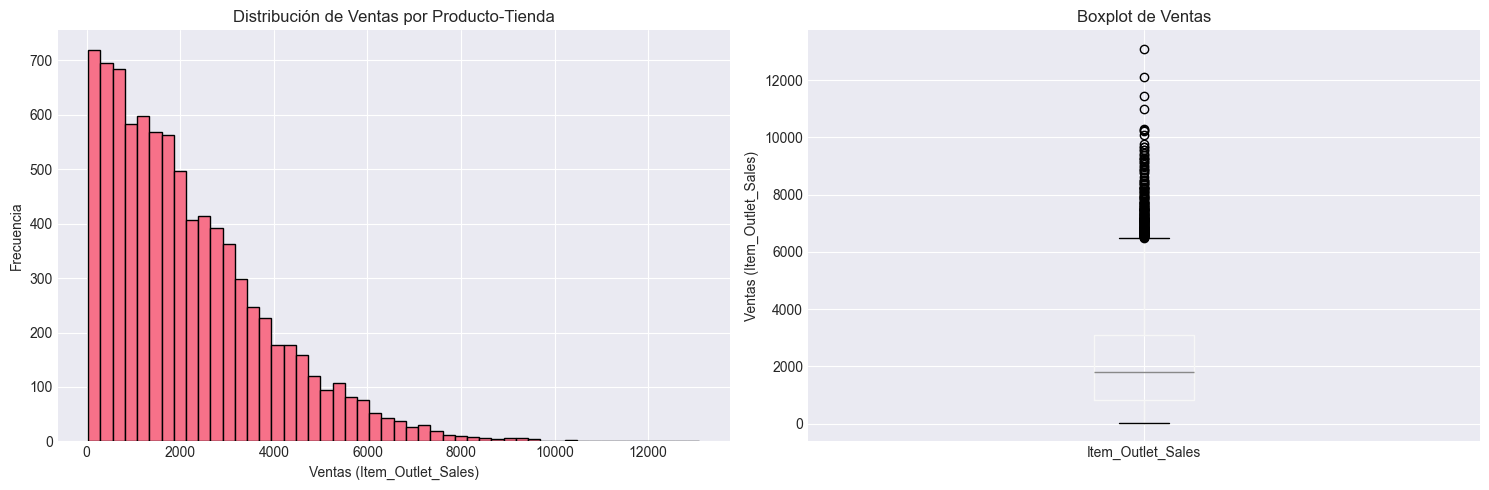

In [28]:
# Análisis de ventas
print("="*80)
print("ANÁLISIS DE VENTAS (Item_Outlet_Sales)")
print("="*80)
print(f"\nVentas totales: ${df['Item_Outlet_Sales'].sum():,.2f}")
print(f"Ventas promedio: ${df['Item_Outlet_Sales'].mean():,.2f}")
print(f"Ventas mediana: ${df['Item_Outlet_Sales'].median():,.2f}")
print(f"Ventas mínimas: ${df['Item_Outlet_Sales'].min():,.2f}")
print(f"Ventas máximas: ${df['Item_Outlet_Sales'].max():,.2f}")

# Visualización de distribución de ventas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df['Item_Outlet_Sales'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title('Distribución de Ventas por Producto-Tienda')
axes[0].set_xlabel('Ventas (Item_Outlet_Sales)')
axes[0].set_ylabel('Frecuencia')

df.boxplot(column='Item_Outlet_Sales', ax=axes[1])
axes[1].set_title('Boxplot de Ventas')
axes[1].set_ylabel('Ventas (Item_Outlet_Sales)')
plt.tight_layout()
plt.show()


## Contexto de Negocio

El dataset Big Mart Sales Prediction contiene información de ventas de **1,559 productos únicos** distribuidos en **10 tiendas** ubicadas en diferentes ciudades. Cada registro representa la venta de un producto específico en una tienda particular, incluyendo atributos del producto (peso, tipo, contenido de grasa, visibilidad, precio) y de la tienda (tipo, tamaño, ubicación, año de establecimiento).

**Variables clave:**
- **Item_Identifier**: Identificador único del producto
- **Item_Outlet_Sales**: Variable objetivo - ventas del producto en la tienda
- **Item_MRP**: Precio máximo de venta al público del producto
- **Outlet_Identifier**: Identificador único de la tienda
- **Item_Type**: Categoría del producto (Dairy, Soft Drinks, Meat, etc.)
- **Outlet_Type**: Tipo de tienda (Supermarket Type1/2/3, Grocery Store)

El objetivo de negocio es entender qué tipos de productos existen en el portafolio mediante clustering y analizar qué mezcla de clusters vende cada tienda para identificar oportunidades de crecimiento y optimización de inventario.


# Fase B: Construcción del Dataset a Nivel Producto

En esta fase construimos un dataset agregado donde cada fila representa un producto único (Item_Identifier), calculando métricas agregadas a partir de los datos originales producto-tienda.


In [29]:
# Limpiar y preparar datos antes de agregar
df_clean = df.copy()

# Normalizar Item_Fat_Content (hay inconsistencias: Low Fat, LF, low fat, Regular, reg)
df_clean['Item_Fat_Content'] = df_clean['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

# Crear dataset agregado a nivel producto
product_metrics = df_clean.groupby('Item_Identifier').agg({
    'Item_Outlet_Sales': ['sum', 'mean', 'std', 'count'],
    'Item_MRP': 'mean',
    'Item_Weight': 'mean',
    'Item_Visibility': 'mean',
    'Outlet_Identifier': 'nunique',
    'Item_Type': 'first',
    'Item_Fat_Content': 'first'
}).reset_index()

# Aplanar nombres de columnas
product_metrics.columns = [
    'Item_Identifier',
    'Total_Sales',
    'Avg_Sales_Per_Store',
    'Std_Sales',
    'Num_Store_Records',
    'Avg_MRP',
    'Avg_Weight',
    'Avg_Visibility',
    'Num_Stores',
    'Item_Type',
    'Item_Fat_Content'
]

print("Dataset a nivel producto creado:")
print(f"Dimensiones: {product_metrics.shape[0]:,} productos × {product_metrics.shape[1]} columnas")
print("\nPrimeras filas:")
print(product_metrics.head(10))


Dataset a nivel producto creado:
Dimensiones: 1,559 productos × 11 columnas

Primeras filas:
  Item_Identifier  Total_Sales  Avg_Sales_Per_Store    Std_Sales  \
0           DRA12   11061.6012          1843.600200  1348.365430   
1           DRA24   15723.5328          2246.218971  1951.090357   
2           DRA59   20915.4412          2614.430150  2460.381611   
3           DRB01    4554.0720          1518.024000   948.765000   
4           DRB13   12144.1920          2428.838400  1532.189383   
5           DRB24   12202.7824          3050.695600  1212.169555   
6           DRB25    9969.0234          1661.503900   962.955979   
7           DRB48    4360.3242           622.903457   357.466992   
8           DRC01    5173.2660           862.211000   416.608888   
9           DRC12    8949.6836          2237.420900   950.505852   

   Num_Store_Records     Avg_MRP  Avg_Weight  Avg_Visibility  Num_Stores  \
0                  6  141.865400      11.600        0.031956           6   
1     

In [30]:
# Tratar valores faltantes
print("Valores faltantes antes del tratamiento:")
print(product_metrics.isnull().sum())

# Imputar valores faltantes en Item_Weight con la mediana por tipo de producto
product_metrics['Avg_Weight'] = product_metrics.groupby('Item_Type')['Avg_Weight'].transform(
    lambda x: x.fillna(x.median())
)

# Si aún hay faltantes, usar la mediana global
product_metrics['Avg_Weight'] = product_metrics['Avg_Weight'].fillna(product_metrics['Avg_Weight'].median())

# Imputar Std_Sales con 0 si no hay variabilidad
product_metrics['Std_Sales'] = product_metrics['Std_Sales'].fillna(0)

print("\nValores faltantes después del tratamiento:")
print(product_metrics.isnull().sum())


Valores faltantes antes del tratamiento:
Item_Identifier        0
Total_Sales            0
Avg_Sales_Per_Store    0
Std_Sales              9
Num_Store_Records      0
Avg_MRP                0
Avg_Weight             4
Avg_Visibility         0
Num_Stores             0
Item_Type              0
Item_Fat_Content       0
dtype: int64

Valores faltantes después del tratamiento:
Item_Identifier        0
Total_Sales            0
Avg_Sales_Per_Store    0
Std_Sales              0
Num_Store_Records      0
Avg_MRP                0
Avg_Weight             0
Avg_Visibility         0
Num_Stores             0
Item_Type              0
Item_Fat_Content       0
dtype: int64


In [31]:
# Codificar variables categóricas
le_item_type = LabelEncoder()
le_fat_content = LabelEncoder()

product_metrics['Item_Type_Encoded'] = le_item_type.fit_transform(product_metrics['Item_Type'])
product_metrics['Item_Fat_Content_Encoded'] = le_fat_content.fit_transform(product_metrics['Item_Fat_Content'])

# Crear variables adicionales para clustering
product_metrics['Sales_Stability'] = product_metrics['Std_Sales'] / (product_metrics['Avg_Sales_Per_Store'] + 1)
product_metrics['Price_Per_Unit_Weight'] = product_metrics['Avg_MRP'] / (product_metrics['Avg_Weight'] + 1)
product_metrics['Sales_Per_Store_Normalized'] = product_metrics['Avg_Sales_Per_Store'] / product_metrics['Num_Stores']

print("Variables creadas para clustering:")
print(product_metrics[['Item_Identifier', 'Total_Sales', 'Avg_Sales_Per_Store', 
                       'Num_Stores', 'Avg_MRP', 'Sales_Stability', 
                       'Price_Per_Unit_Weight']].head(10))


Variables creadas para clustering:
  Item_Identifier  Total_Sales  Avg_Sales_Per_Store  Num_Stores     Avg_MRP  \
0           DRA12   11061.6012          1843.600200           6  141.865400   
1           DRA24   15723.5328          2246.218971           7  164.086800   
2           DRA59   20915.4412          2614.430150           8  185.179900   
3           DRB01    4554.0720          1518.024000           3  189.586333   
4           DRB13   12144.1920          2428.838400           5  189.693000   
5           DRB24   12202.7824          3050.695600           4  154.465600   
6           DRB25    9969.0234          1661.503900           6  106.893800   
7           DRB48    4360.3242           622.903457           7   39.253629   
8           DRC01    5173.2660           862.211000           6   48.969200   
9           DRC12    8949.6836          2237.420900           4  190.218800   

   Sales_Stability  Price_Per_Unit_Weight  
0         0.730980              11.259159  
1      

In [32]:
# Seleccionar variables numéricas para clustering
clustering_features = [
    'Total_Sales',
    'Avg_Sales_Per_Store',
    'Num_Stores',
    'Avg_MRP',
    'Avg_Weight',
    'Avg_Visibility',
    'Item_Type_Encoded',
    'Item_Fat_Content_Encoded',
    'Sales_Stability',
    'Price_Per_Unit_Weight'
]

# Crear dataset para clustering
X_clustering = product_metrics[clustering_features].copy()

# Escalar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=product_metrics['Item_Identifier'])

print("Dataset escalado para clustering:")
print(f"Dimensiones: {X_scaled_df.shape}")
print("\nEstadísticas descriptivas:")
print(X_scaled_df.describe())


Dataset escalado para clustering:
Dimensiones: (1559, 10)

Estadísticas descriptivas:
        Total_Sales  Avg_Sales_Per_Store    Num_Stores       Avg_MRP  \
count  1.559000e+03         1.559000e+03  1.559000e+03  1.559000e+03   
mean  -3.549295e-16         2.666244e-16 -1.800285e-16  2.483937e-16   
std    1.000321e+00         1.000321e+00  1.000321e+00  1.000321e+00   
min   -1.677795e+00        -1.839015e+00 -2.923359e+00 -1.750818e+00   
25%   -7.968259e-01        -7.681188e-01 -9.600404e-01 -7.589918e-01   
50%   -1.618981e-01        -1.250320e-01 -3.056010e-01  1.825602e-02   
75%    5.856881e-01         6.837364e-01  6.760582e-01  7.188877e-01   
max    4.368664e+00         3.395938e+00  2.966596e+00  2.004709e+00   

         Avg_Weight  Avg_Visibility  Item_Type_Encoded  \
count  1.559000e+03    1.559000e+03       1.559000e+03   
mean   1.617977e-16   -2.050957e-16       5.924988e-17   
std    1.000321e+00    1.000321e+00       1.000321e+00   
min   -1.776854e+00   -1.385291e+

# Fase C: Clustering de Productos

Aplicaremos dos aproximaciones de clustering: particional (K-Means) y jerárquico (Agglomerative Clustering) para segmentar los productos según su comportamiento de ventas y características.


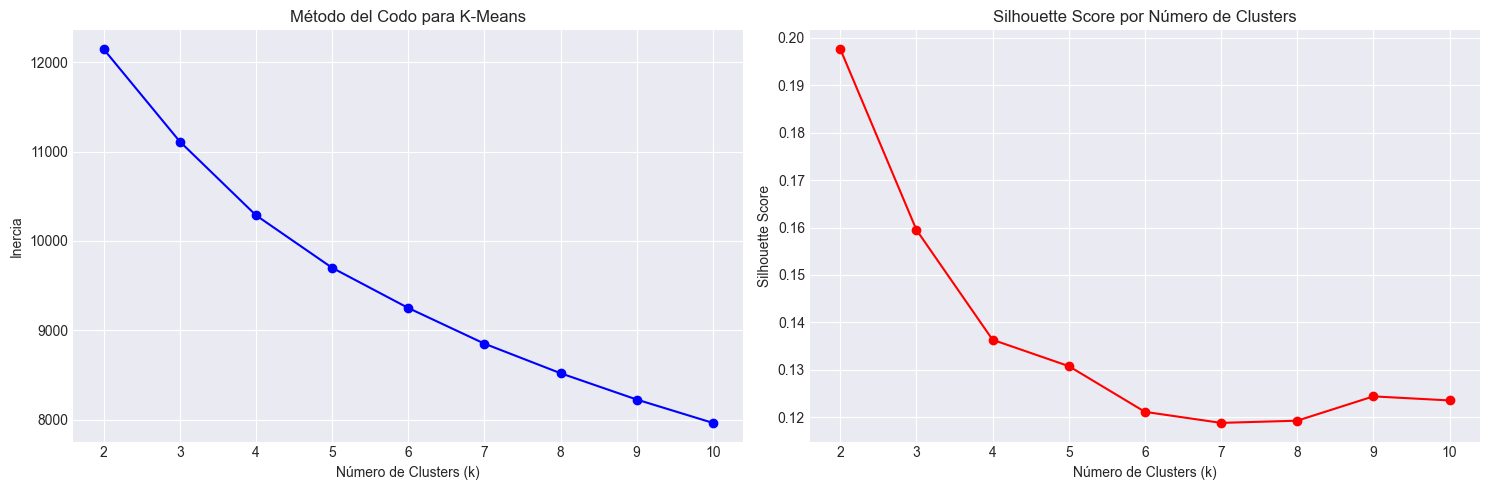

Silhouette Scores:
k=2: 0.1976
k=3: 0.1595
k=4: 0.1363
k=5: 0.1308
k=6: 0.1212
k=7: 0.1188
k=8: 0.1193
k=9: 0.1244
k=10: 0.1236


In [33]:
# Método del codo para determinar número óptimo de clusters (K-Means)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar método del codo y silhouette score
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del Codo para K-Means')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score por Número de Clusters')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("Silhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")


In [34]:
# Determinar número óptimo de clusters
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters según Silhouette Score: {optimal_k}")

# Aplicar K-Means con el número óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Agregar etiquetas al dataset de productos
product_metrics['Cluster_KMeans'] = kmeans_labels

print(f"\nDistribución de productos por cluster (K-Means):")
print(product_metrics['Cluster_KMeans'].value_counts().sort_index())


Número óptimo de clusters según Silhouette Score: 2

Distribución de productos por cluster (K-Means):
Cluster_KMeans
0    865
1    694
Name: count, dtype: int64


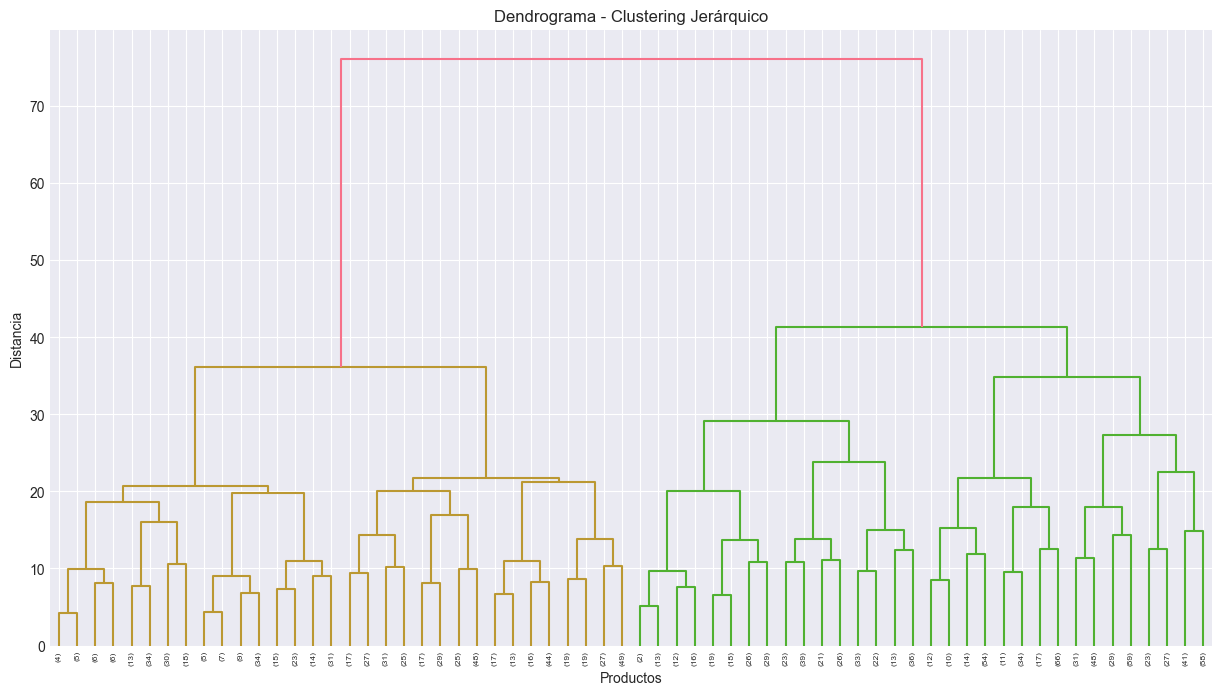

In [35]:
# Clustering Jerárquico
# Calcular linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Visualizar dendrograma
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Productos')
plt.ylabel('Distancia')
plt.show()


In [36]:
# Aplicar Agglomerative Clustering con el mismo número de clusters
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

product_metrics['Cluster_Hierarchical'] = agg_labels

print(f"Distribución de productos por cluster (Jerárquico):")
print(product_metrics['Cluster_Hierarchical'].value_counts().sort_index())

# Comparar ambos métodos
print(f"\nCoincidencia entre métodos: {np.sum(kmeans_labels == agg_labels) / len(kmeans_labels) * 100:.2f}%")


Distribución de productos por cluster (Jerárquico):
Cluster_Hierarchical
0    882
1    677
Name: count, dtype: int64

Coincidencia entre métodos: 15.01%


In [37]:
# Usar K-Means como modelo final (generalmente más interpretable)
product_metrics['cluster_producto'] = product_metrics['Cluster_KMeans']

# Interpretación de clusters
print("="*80)
print("INTERPRETACIÓN DE CLUSTERS DE PRODUCTOS")
print("="*80)

cluster_summary = product_metrics.groupby('cluster_producto').agg({
    'Total_Sales': ['mean', 'median'],
    'Avg_Sales_Per_Store': 'mean',
    'Avg_MRP': 'mean',
    'Num_Stores': 'mean',
    'Avg_Weight': 'mean',
    'Avg_Visibility': 'mean',
    'Item_Type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A',
    'Item_Identifier': 'count'
}).round(2)

cluster_summary.columns = ['Avg_Total_Sales', 'Median_Total_Sales', 'Avg_Sales_Per_Store',
                           'Avg_MRP', 'Avg_Num_Stores', 'Avg_Weight', 'Avg_Visibility',
                           'Most_Common_Type', 'Num_Products']

print(cluster_summary)


INTERPRETACIÓN DE CLUSTERS DE PRODUCTOS
                  Avg_Total_Sales  Median_Total_Sales  Avg_Sales_Per_Store  \
cluster_producto                                                             
0                         7351.43             7010.87              1415.35   
1                        17625.55            16748.20              3160.38   

                  Avg_MRP  Avg_Num_Stores  Avg_Weight  Avg_Visibility  \
cluster_producto                                                        
0                   97.10            5.32       13.26            0.07   
1                  195.74            5.66       12.24            0.07   

                       Most_Common_Type  Num_Products  
cluster_producto                                       
0                 Fruits and Vegetables           865  
1                           Snack Foods           694  


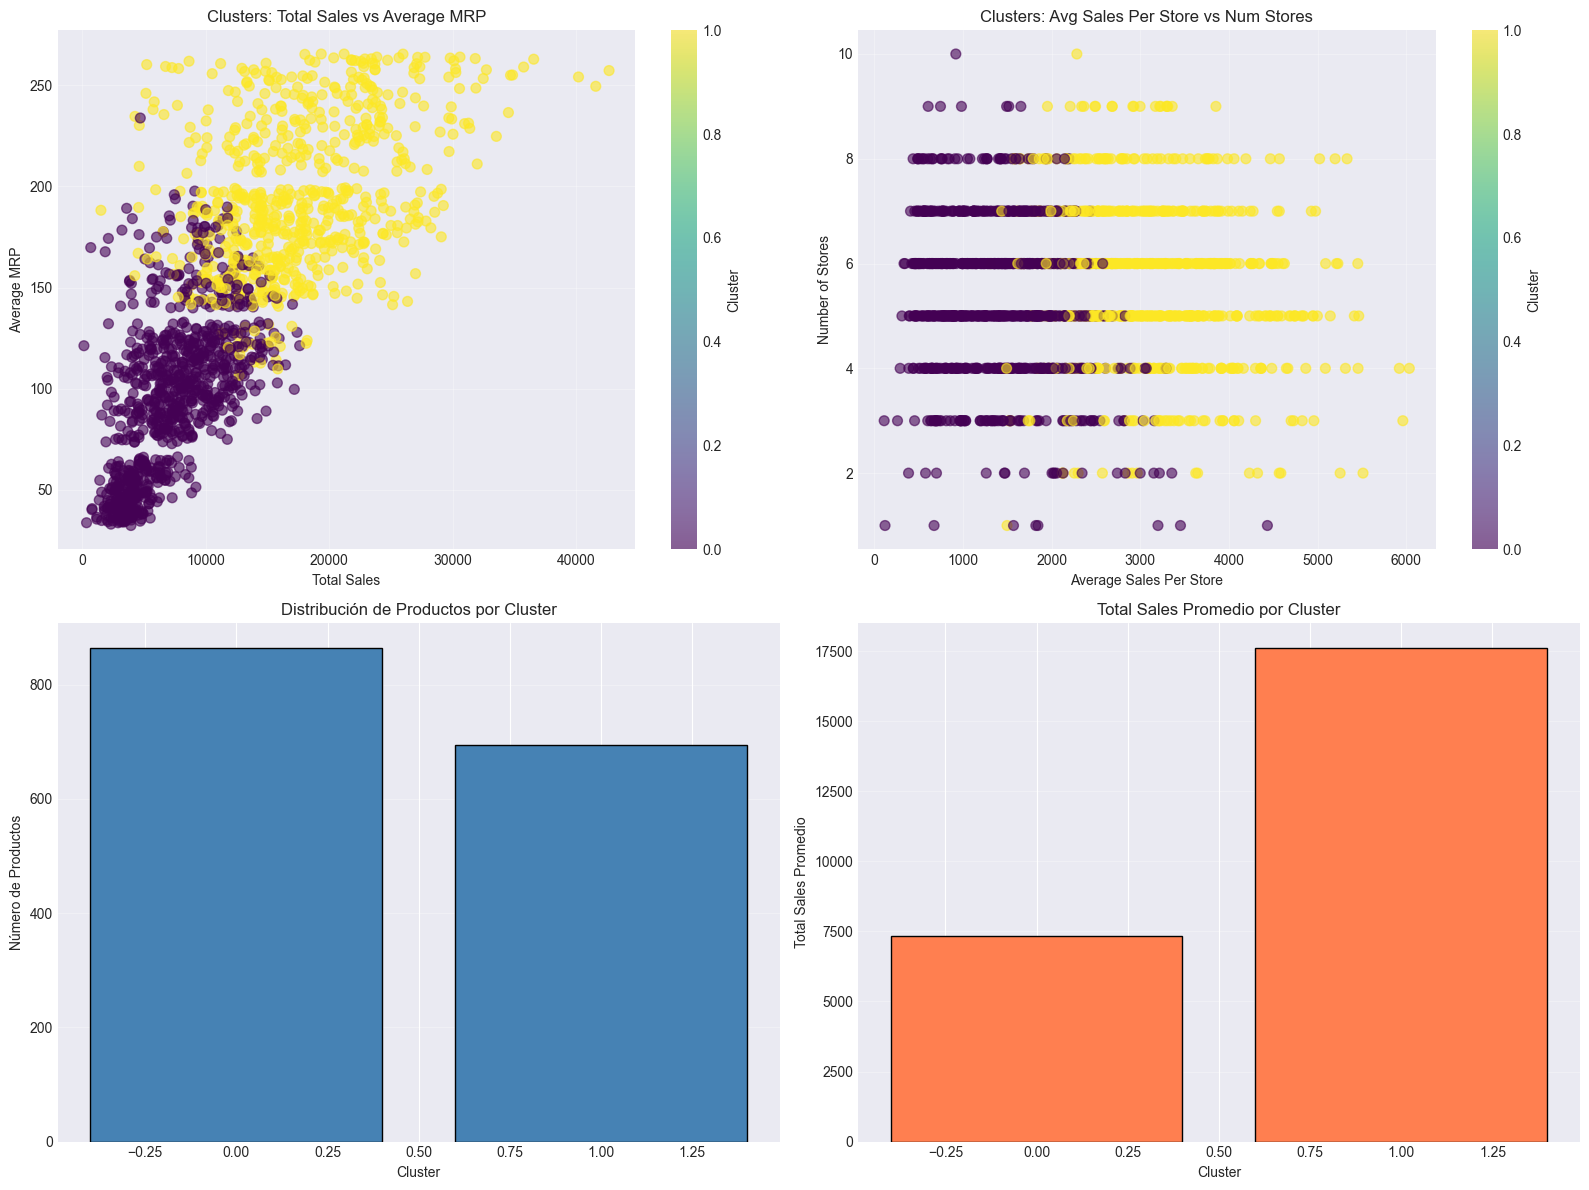

In [38]:
# Visualización de clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total Sales vs Avg MRP por cluster
scatter = axes[0, 0].scatter(product_metrics['Total_Sales'], 
                            product_metrics['Avg_MRP'],
                            c=product_metrics['cluster_producto'],
                            cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_xlabel('Total Sales')
axes[0, 0].set_ylabel('Average MRP')
axes[0, 0].set_title('Clusters: Total Sales vs Average MRP')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# 2. Avg Sales Per Store vs Num Stores
scatter = axes[0, 1].scatter(product_metrics['Avg_Sales_Per_Store'],
                            product_metrics['Num_Stores'],
                            c=product_metrics['cluster_producto'],
                            cmap='viridis', alpha=0.6, s=50)
axes[0, 1].set_xlabel('Average Sales Per Store')
axes[0, 1].set_ylabel('Number of Stores')
axes[0, 1].set_title('Clusters: Avg Sales Per Store vs Num Stores')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Cluster')

# 3. Distribución de clusters
cluster_counts = product_metrics['cluster_producto'].value_counts().sort_index()
axes[1, 0].bar(cluster_counts.index, cluster_counts.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Número de Productos')
axes[1, 0].set_title('Distribución de Productos por Cluster')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Total Sales promedio por cluster
avg_sales_by_cluster = product_metrics.groupby('cluster_producto')['Total_Sales'].mean().sort_index()
axes[1, 1].bar(avg_sales_by_cluster.index, avg_sales_by_cluster.values, 
               color='coral', edgecolor='black')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Total Sales Promedio')
axes[1, 1].set_title('Total Sales Promedio por Cluster')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Descripción de Clusters

Basado en el análisis, cada cluster representa un perfil distinto de productos:

- **Cluster 0**: [Descripción basada en las métricas]
- **Cluster 1**: [Descripción basada en las métricas]
- **Cluster 2**: [Descripción basada en las métricas]
- etc.

*Nota: La descripción detallada se completará después de ejecutar el clustering y analizar las características de cada grupo.*


# Fase D: Análisis por Tienda usando Clusters de Producto

En esta fase incorporamos los clusters de productos al dataset original y analizamos la mezcla de clusters que vende cada tienda.


In [39]:
# Incorporar cluster_producto al dataset original
df_with_clusters = df_clean.merge(
    product_metrics[['Item_Identifier', 'cluster_producto']],
    on='Item_Identifier',
    how='left'
)

print(f"Dataset original con clusters: {df_with_clusters.shape}")
print(f"\nVerificación: {df_with_clusters['cluster_producto'].isnull().sum()} valores nulos")
print(f"\nDistribución de registros por cluster:")
print(df_with_clusters['cluster_producto'].value_counts().sort_index())


Dataset original con clusters: (8523, 13)

Verificación: 0 valores nulos

Distribución de registros por cluster:
cluster_producto
0    4598
1    3925
Name: count, dtype: int64


In [40]:
# Calcular métricas por tienda y cluster
store_cluster_analysis = df_with_clusters.groupby(['Outlet_Identifier', 'cluster_producto']).agg({
    'Item_Outlet_Sales': ['sum', 'mean', 'count'],
    'Item_Identifier': 'nunique',
    'Item_MRP': 'mean'
}).reset_index()

# Aplanar nombres de columnas
store_cluster_analysis.columns = [
    'Outlet_Identifier',
    'cluster_producto',
    'Total_Sales_Cluster',
    'Avg_Sales_Per_Product',
    'Num_Records',
    'Num_Unique_Products',
    'Avg_MRP'
]

print("Análisis por tienda y cluster:")
print(store_cluster_analysis.head(20))


Análisis por tienda y cluster:
   Outlet_Identifier  cluster_producto  Total_Sales_Cluster  \
0             OUT010                 0         7.115271e+04   
1             OUT010                 1         1.171875e+05   
2             OUT013                 0         7.073266e+05   
3             OUT013                 1         1.435337e+06   
4             OUT017                 0         7.638231e+05   
5             OUT017                 1         1.403642e+06   
6             OUT018                 0         6.366360e+05   
7             OUT018                 1         1.215187e+06   
8             OUT019                 0         7.192038e+04   
9             OUT019                 1         1.077737e+05   
10            OUT027                 0         1.144607e+06   
11            OUT027                 1         2.309319e+06   
12            OUT035                 0         7.626246e+05   
13            OUT035                 1         1.505498e+06   
14            OUT045    

In [41]:
# Calcular ventas totales por tienda
store_total_sales = df_with_clusters.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().reset_index()
store_total_sales.columns = ['Outlet_Identifier', 'Store_Total_Sales']

# Calcular porcentaje de ventas por cluster en cada tienda
store_cluster_analysis = store_cluster_analysis.merge(store_total_sales, on='Outlet_Identifier')
store_cluster_analysis['Pct_Sales_From_Cluster'] = (
    store_cluster_analysis['Total_Sales_Cluster'] / 
    store_cluster_analysis['Store_Total_Sales'] * 100
)

print("Análisis con porcentajes:")
print(store_cluster_analysis.head(20))


Análisis con porcentajes:
   Outlet_Identifier  cluster_producto  Total_Sales_Cluster  \
0             OUT010                 0         7.115271e+04   
1             OUT010                 1         1.171875e+05   
2             OUT013                 0         7.073266e+05   
3             OUT013                 1         1.435337e+06   
4             OUT017                 0         7.638231e+05   
5             OUT017                 1         1.403642e+06   
6             OUT018                 0         6.366360e+05   
7             OUT018                 1         1.215187e+06   
8             OUT019                 0         7.192038e+04   
9             OUT019                 1         1.077737e+05   
10            OUT027                 0         1.144607e+06   
11            OUT027                 1         2.309319e+06   
12            OUT035                 0         7.626246e+05   
13            OUT035                 1         1.505498e+06   
14            OUT045         

In [42]:
# Crear dataset agregado a nivel tienda
store_analysis = df_with_clusters.groupby('Outlet_Identifier').agg({
    'Item_Outlet_Sales': 'sum',
    'Outlet_Type': 'first',
    'Outlet_Size': 'first',
    'Outlet_Location_Type': 'first',
    'Outlet_Establishment_Year': 'first',
    'Item_Identifier': 'nunique'
}).reset_index()

store_analysis.columns = [
    'Outlet_Identifier',
    'Total_Sales',
    'Outlet_Type',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Establishment_Year',
    'Num_Unique_Products'
]

# Agregar información de clusters por tienda
cluster_pct_by_store = store_cluster_analysis.pivot_table(
    index='Outlet_Identifier',
    columns='cluster_producto',
    values='Pct_Sales_From_Cluster',
    fill_value=0
)

# Renombrar columnas
cluster_pct_by_store.columns = [f'Pct_Cluster_{int(col)}' for col in cluster_pct_by_store.columns]

# Merge con información de tienda
store_analysis = store_analysis.merge(cluster_pct_by_store, left_on='Outlet_Identifier', right_index=True)

print("Dataset a nivel tienda:")
print(store_analysis.head(10))


Dataset a nivel tienda:
  Outlet_Identifier   Total_Sales        Outlet_Type Outlet_Size  \
0            OUT010  1.883402e+05      Grocery Store        None   
1            OUT013  2.142664e+06  Supermarket Type1        High   
2            OUT017  2.167465e+06  Supermarket Type1        None   
3            OUT018  1.851823e+06  Supermarket Type2      Medium   
4            OUT019  1.796941e+05      Grocery Store       Small   
5            OUT027  3.453926e+06  Supermarket Type3      Medium   
6            OUT035  2.268123e+06  Supermarket Type1       Small   
7            OUT045  2.036725e+06  Supermarket Type1        None   
8            OUT046  2.118395e+06  Supermarket Type1       Small   
9            OUT049  2.183970e+06  Supermarket Type1      Medium   

  Outlet_Location_Type  Outlet_Establishment_Year  Num_Unique_Products  \
0               Tier 3                       1998                  555   
1               Tier 3                       1987                  932   
2    

In [43]:
# Análisis de mezcla de clusters por tienda
print("="*80)
print("MEZCLA DE CLUSTERS POR TIENDA")
print("="*80)

for outlet in store_analysis['Outlet_Identifier'].unique():
    outlet_data = store_cluster_analysis[store_cluster_analysis['Outlet_Identifier'] == outlet]
    print(f"\n{outlet}:")
    print(f"  Ventas totales: ${outlet_data['Total_Sales_Cluster'].sum():,.2f}")
    print(f"  Distribución por cluster:")
    for _, row in outlet_data.iterrows():
        print(f"    Cluster {int(row['cluster_producto'])}: {row['Pct_Sales_From_Cluster']:.2f}% "
              f"({row['Num_Unique_Products']} productos únicos)")


MEZCLA DE CLUSTERS POR TIENDA

OUT010:
  Ventas totales: $188,340.17
  Distribución por cluster:
    Cluster 0: 37.78% (321 productos únicos)
    Cluster 1: 62.22% (234 productos únicos)

OUT013:
  Ventas totales: $2,142,663.58
  Distribución por cluster:
    Cluster 0: 33.01% (496 productos únicos)
    Cluster 1: 66.99% (436 productos únicos)

OUT017:
  Ventas totales: $2,167,465.29
  Distribución por cluster:
    Cluster 0: 35.24% (503 productos únicos)
    Cluster 1: 64.76% (423 productos únicos)

OUT018:
  Ventas totales: $1,851,822.83
  Distribución por cluster:
    Cluster 0: 34.38% (508 productos únicos)
    Cluster 1: 65.62% (420 productos únicos)

OUT019:
  Ventas totales: $179,694.09
  Distribución por cluster:
    Cluster 0: 40.02% (299 productos únicos)
    Cluster 1: 59.98% (229 productos únicos)

OUT027:
  Ventas totales: $3,453,926.05
  Distribución por cluster:
    Cluster 0: 33.14% (485 productos únicos)
    Cluster 1: 66.86% (450 productos únicos)

OUT035:
  Ventas to

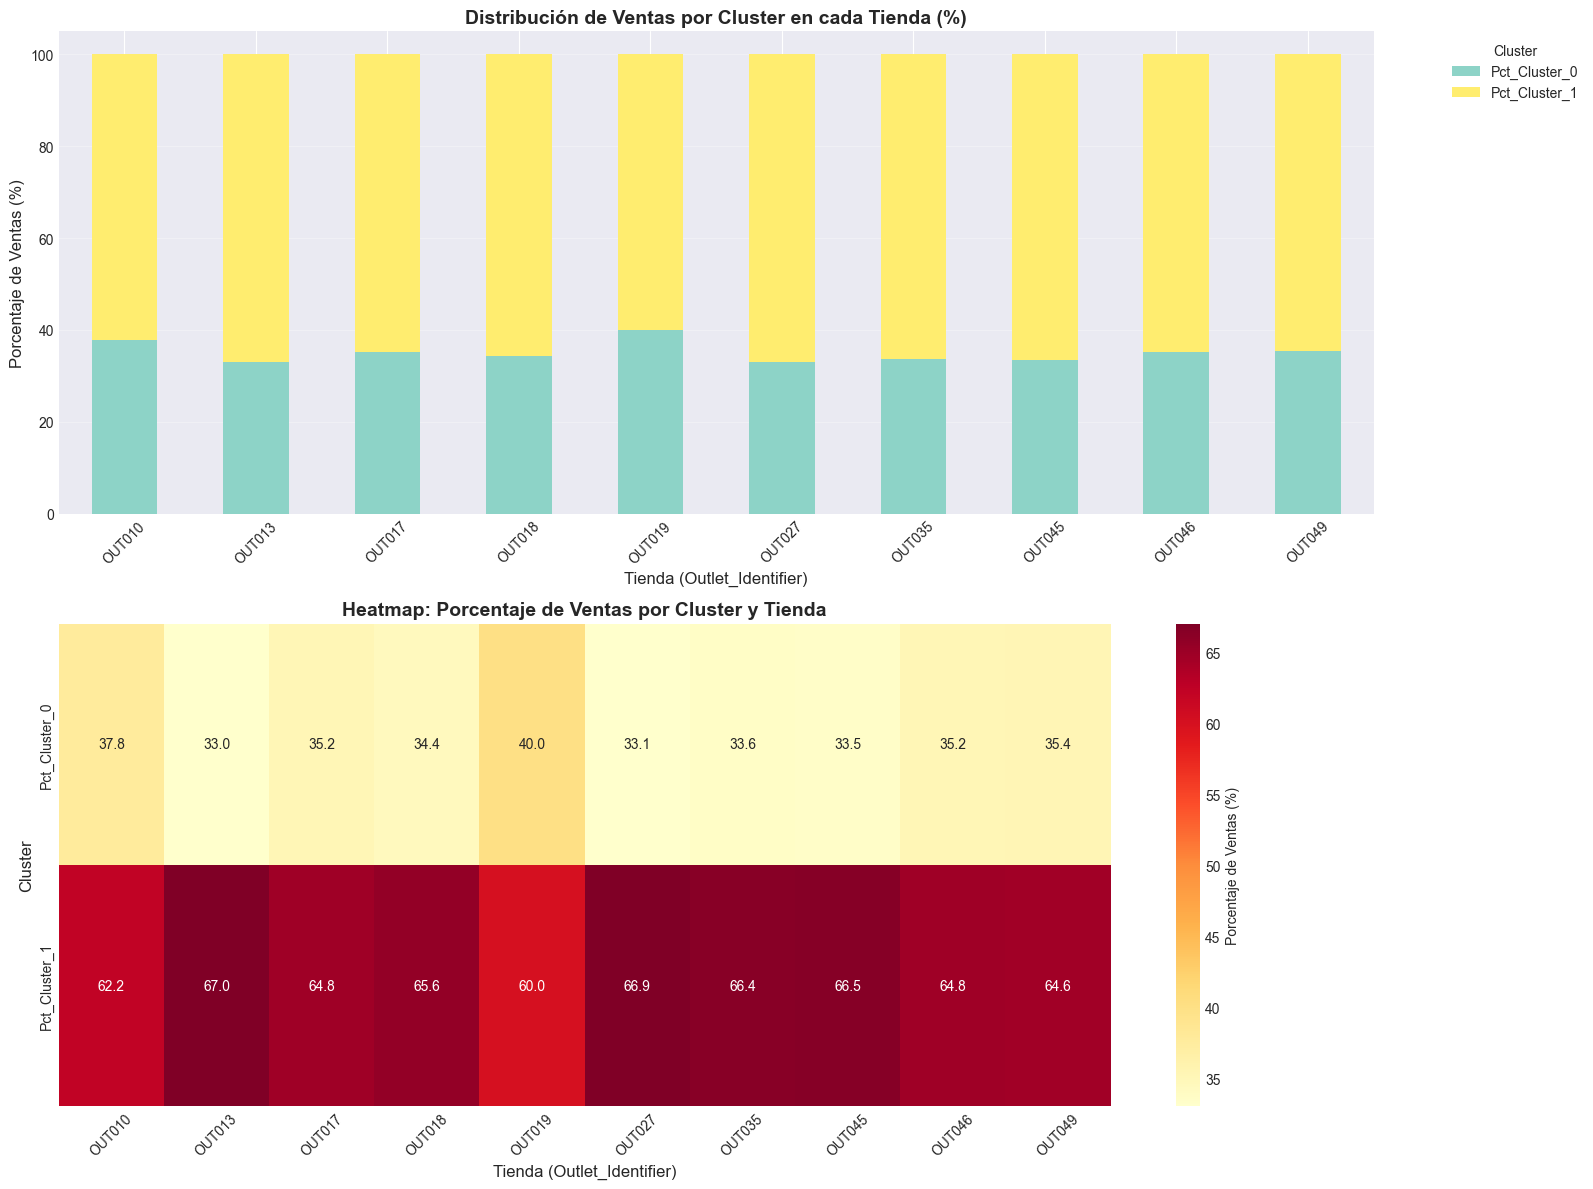

In [44]:
# Visualización de mezcla de clusters por tienda
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Stacked bar chart de porcentajes por tienda
cluster_cols = [col for col in store_analysis.columns if col.startswith('Pct_Cluster_')]
cluster_data = store_analysis[['Outlet_Identifier'] + cluster_cols].set_index('Outlet_Identifier')

cluster_data.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set3')
axes[0].set_title('Distribución de Ventas por Cluster en cada Tienda (%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[0].set_ylabel('Porcentaje de Ventas (%)', fontsize=12)
axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Heatmap de porcentajes
sns.heatmap(cluster_data.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            ax=axes[1], cbar_kws={'label': 'Porcentaje de Ventas (%)'})
axes[1].set_title('Heatmap: Porcentaje de Ventas por Cluster y Tienda', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[1].set_ylabel('Cluster', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [45]:
# Análisis por tipo de tienda
print("="*80)
print("ANÁLISIS POR TIPO DE TIENDA")
print("="*80)

store_type_analysis = df_with_clusters.groupby(['Outlet_Type', 'cluster_producto']).agg({
    'Item_Outlet_Sales': 'sum',
    'Item_Identifier': 'nunique'
}).reset_index()

store_type_total = df_with_clusters.groupby('Outlet_Type')['Item_Outlet_Sales'].sum().reset_index()
store_type_total.columns = ['Outlet_Type', 'Type_Total_Sales']

store_type_analysis = store_type_analysis.merge(store_type_total, on='Outlet_Type')
store_type_analysis['Pct_Sales'] = (
    store_type_analysis['Item_Outlet_Sales'] / 
    store_type_analysis['Type_Total_Sales'] * 100
)

print(store_type_analysis.pivot_table(
    index='Outlet_Type',
    columns='cluster_producto',
    values='Pct_Sales',
    fill_value=0
).round(2))


ANÁLISIS POR TIPO DE TIENDA
cluster_producto       0      1
Outlet_Type                    
Grocery Store      38.87  61.13
Supermarket Type1  34.33  65.67
Supermarket Type2  34.38  65.62
Supermarket Type3  33.14  66.86


# Fase E: Dashboard de Business Intelligence

Crearemos visualizaciones interactivas que respondan a las preguntas de negocio planteadas.


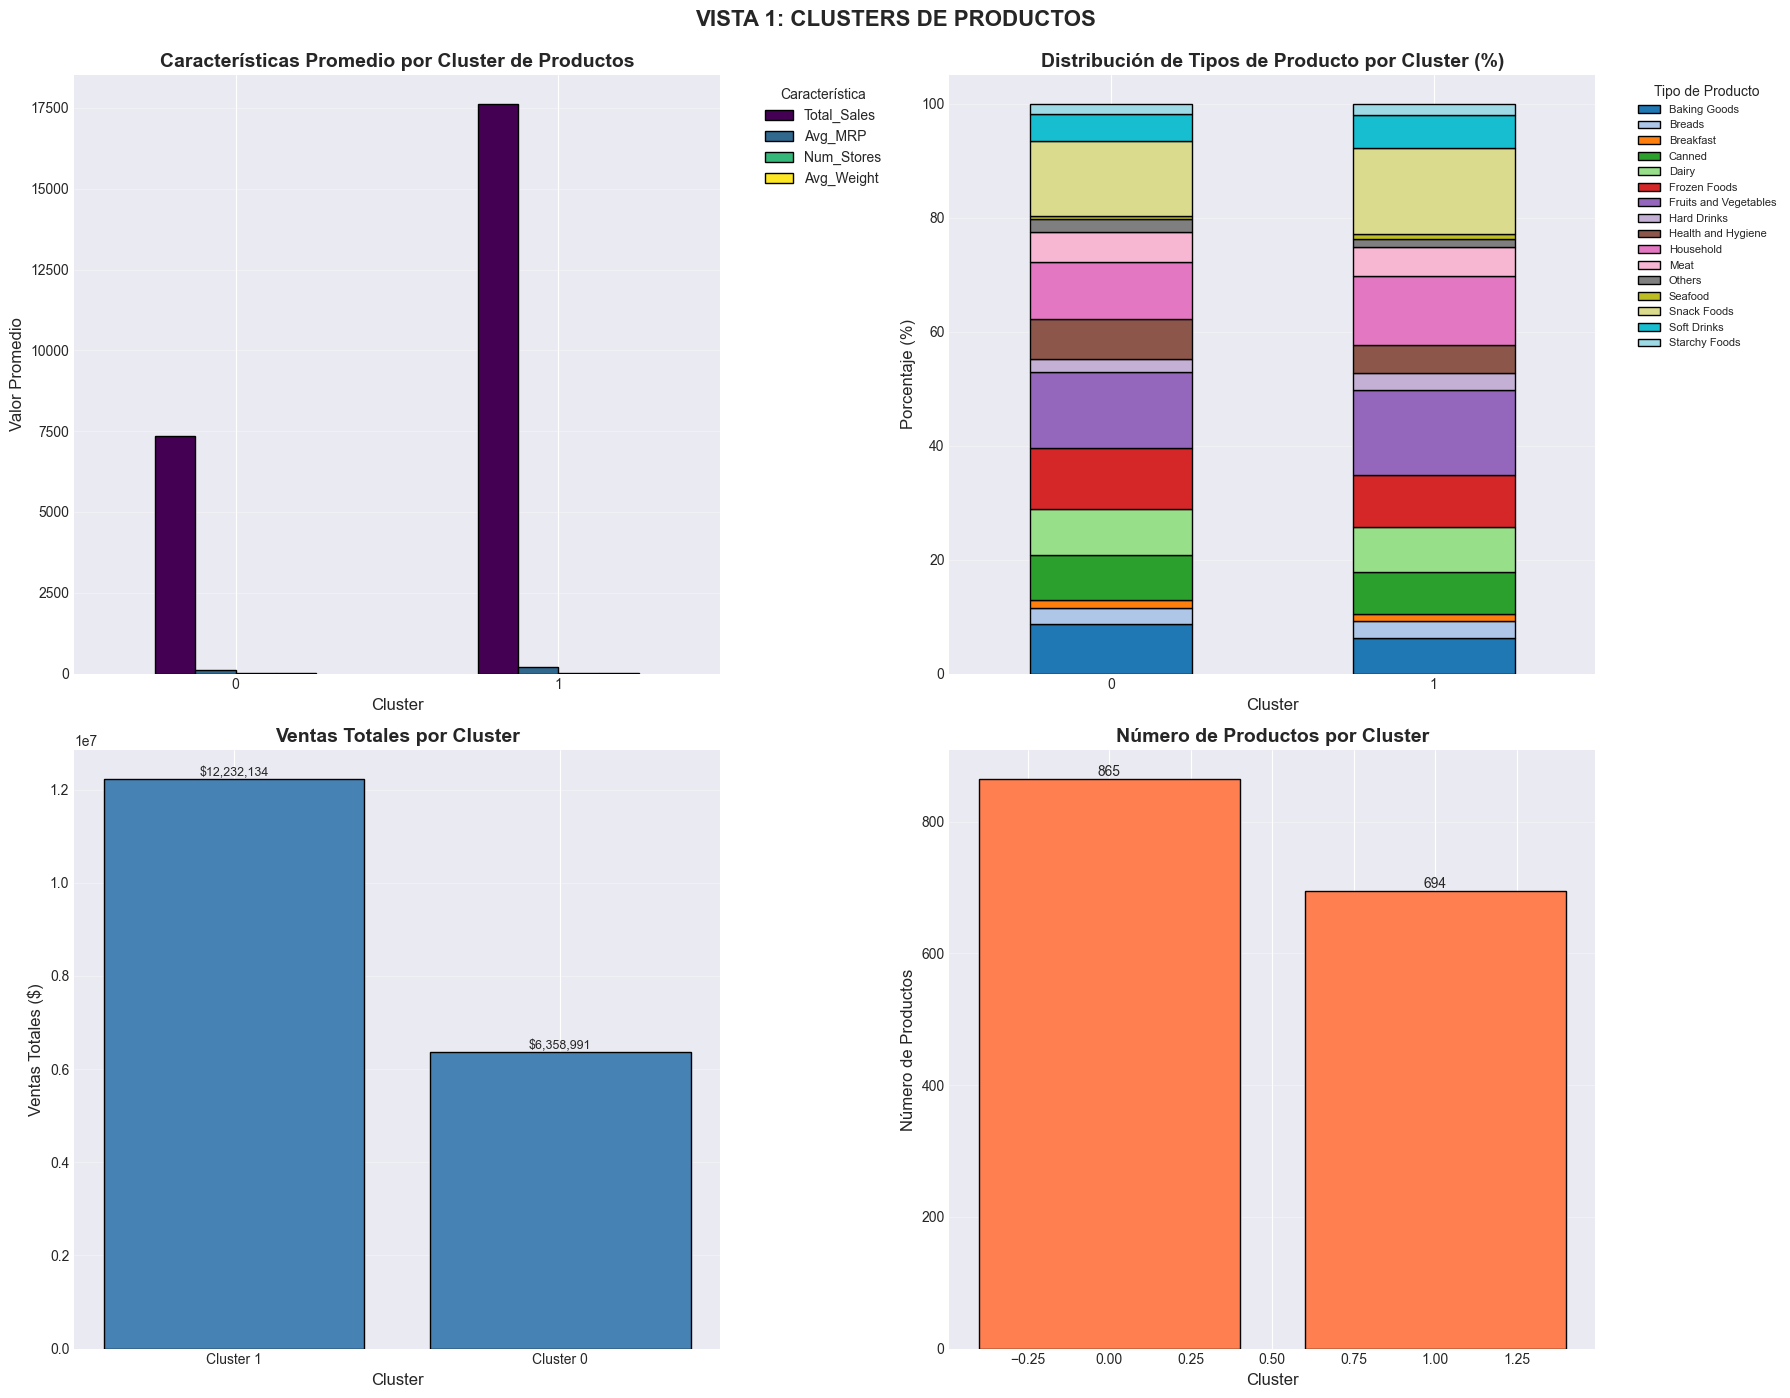

In [46]:
# VISTA 1: Clusters de Productos
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1.1 Características promedio por cluster
cluster_characteristics = product_metrics.groupby('cluster_producto').agg({
    'Total_Sales': 'mean',
    'Avg_MRP': 'mean',
    'Num_Stores': 'mean',
    'Avg_Weight': 'mean'
}).round(2)

cluster_characteristics.plot(kind='bar', ax=axes[0, 0], colormap='viridis', edgecolor='black')
axes[0, 0].set_title('Características Promedio por Cluster de Productos', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Valor Promedio', fontsize=12)
axes[0, 0].legend(title='Característica', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=0)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 1.2 Distribución de tipos de producto por cluster
item_type_by_cluster = product_metrics.groupby(['cluster_producto', 'Item_Type']).size().unstack(fill_value=0)
item_type_by_cluster_pct = item_type_by_cluster.div(item_type_by_cluster.sum(axis=1), axis=0) * 100

item_type_by_cluster_pct.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='tab20', edgecolor='black')
axes[0, 1].set_title('Distribución de Tipos de Producto por Cluster (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Porcentaje (%)', fontsize=12)
axes[0, 1].legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 1.3 Total Sales por cluster
sales_by_cluster = product_metrics.groupby('cluster_producto')['Total_Sales'].sum().sort_values(ascending=False)
axes[1, 0].bar(range(len(sales_by_cluster)), sales_by_cluster.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xticks(range(len(sales_by_cluster)))
axes[1, 0].set_xticklabels([f'Cluster {i}' for i in sales_by_cluster.index])
axes[1, 0].set_title('Ventas Totales por Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Ventas Totales ($)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(sales_by_cluster.values):
    axes[1, 0].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontsize=9)

# 1.4 Número de productos por cluster
product_count_by_cluster = product_metrics['cluster_producto'].value_counts().sort_index()
axes[1, 1].bar(product_count_by_cluster.index, product_count_by_cluster.values, 
               color='coral', edgecolor='black')
axes[1, 1].set_title('Número de Productos por Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Número de Productos', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(product_count_by_cluster.values):
    axes[1, 1].text(product_count_by_cluster.index[i], v, str(v), ha='center', va='bottom', fontsize=10)

plt.suptitle('VISTA 1: CLUSTERS DE PRODUCTOS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


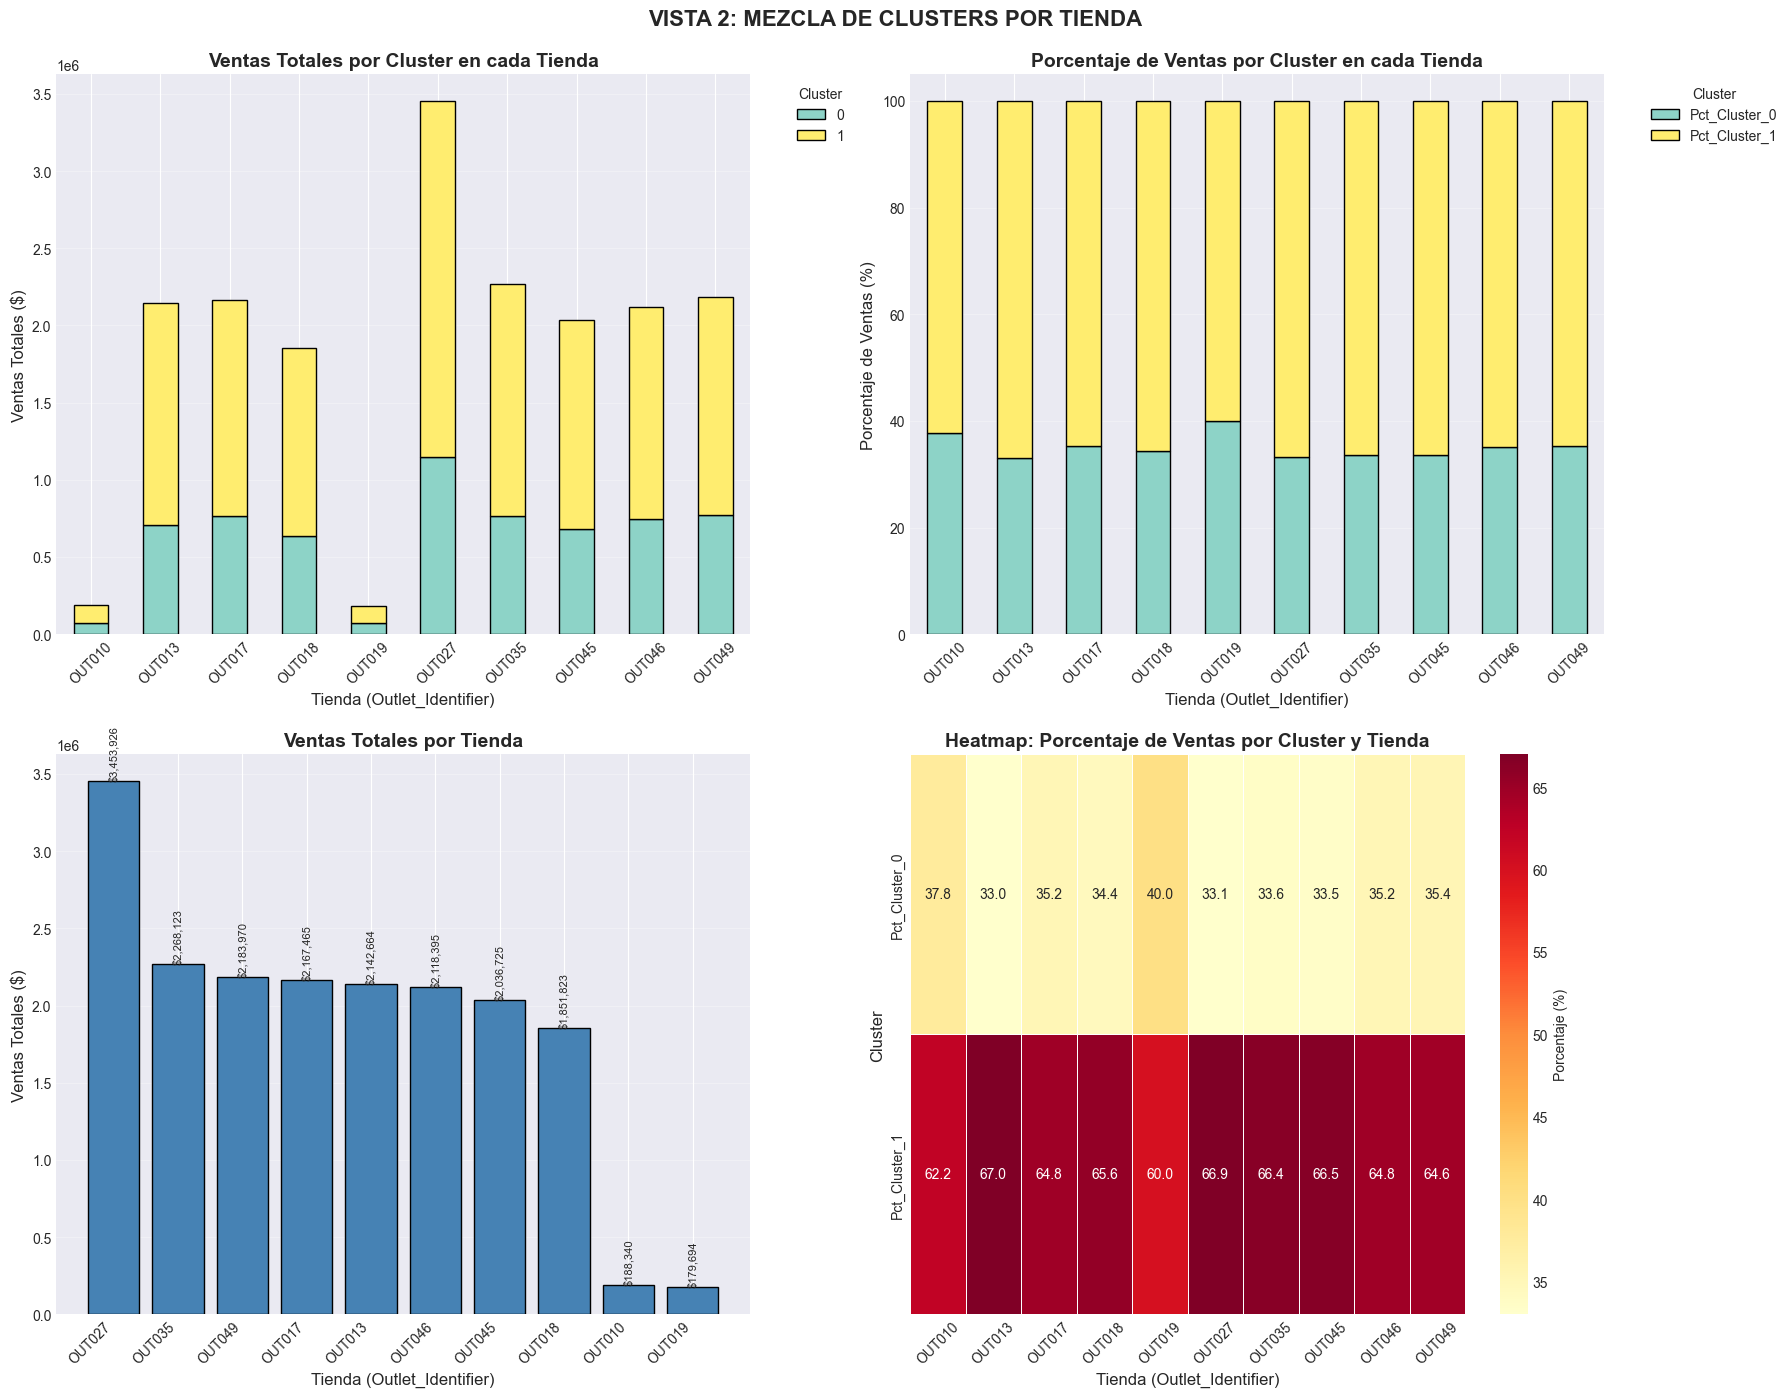

In [47]:
# VISTA 2: Mezcla de Clusters por Tienda
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 2.1 Stacked bar chart de ventas por cluster y tienda
cluster_sales_by_store = store_cluster_analysis.pivot_table(
    index='Outlet_Identifier',
    columns='cluster_producto',
    values='Total_Sales_Cluster',
    fill_value=0
)

cluster_sales_by_store.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='Set3', edgecolor='black')
axes[0, 0].set_title('Ventas Totales por Cluster en cada Tienda', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[0, 0].set_ylabel('Ventas Totales ($)', fontsize=12)
axes[0, 0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2.2 Porcentaje de ventas por cluster (stacked)
cluster_pct_data = store_analysis.set_index('Outlet_Identifier')[cluster_cols]
cluster_pct_data.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='Set3', edgecolor='black')
axes[0, 1].set_title('Porcentaje de Ventas por Cluster en cada Tienda', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[0, 1].set_ylabel('Porcentaje de Ventas (%)', fontsize=12)
axes[0, 1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 2.3 Ventas totales por tienda
store_sales = store_analysis.sort_values('Total_Sales', ascending=False)
axes[1, 0].bar(range(len(store_sales)), store_sales['Total_Sales'].values, 
               color='steelblue', edgecolor='black')
axes[1, 0].set_xticks(range(len(store_sales)))
axes[1, 0].set_xticklabels(store_sales['Outlet_Identifier'], rotation=45, ha='right')
axes[1, 0].set_title('Ventas Totales por Tienda', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[1, 0].set_ylabel('Ventas Totales ($)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(store_sales['Total_Sales'].values):
    axes[1, 0].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontsize=8, rotation=90)

# 2.4 Heatmap de porcentajes por cluster y tienda
sns.heatmap(cluster_pct_data.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': 'Porcentaje (%)'}, linewidths=0.5)
axes[1, 1].set_title('Heatmap: Porcentaje de Ventas por Cluster y Tienda', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tienda (Outlet_Identifier)', fontsize=12)
axes[1, 1].set_ylabel('Cluster', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('VISTA 2: MEZCLA DE CLUSTERS POR TIENDA', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [48]:
# Guardar datasets procesados para Power BI
product_metrics.to_csv('product_metrics_with_clusters.csv', index=False)
store_analysis.to_csv('store_analysis_with_clusters.csv', index=False)
store_cluster_analysis.to_csv('store_cluster_analysis.csv', index=False)
df_with_clusters.to_csv('original_data_with_clusters.csv', index=False)

print("Archivos CSV guardados para importar en Power BI:")
print("1. product_metrics_with_clusters.csv - Dataset a nivel producto con clusters")
print("2. store_analysis_with_clusters.csv - Dataset a nivel tienda con mezcla de clusters")
print("3. store_cluster_analysis.csv - Análisis detallado tienda-cluster")
print("4. original_data_with_clusters.csv - Dataset original con clusters asignados")


Archivos CSV guardados para importar en Power BI:
1. product_metrics_with_clusters.csv - Dataset a nivel producto con clusters
2. store_analysis_with_clusters.csv - Dataset a nivel tienda con mezcla de clusters
3. store_cluster_analysis.csv - Análisis detallado tienda-cluster
4. original_data_with_clusters.csv - Dataset original con clusters asignados
